# Final Report: OpenCV NLP Project

##### Dani Bojado and Matthew Mays

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats

import re
import os
import requests
from requests import get
from os import path
from bs4 import BeautifulSoup

import json
import unicodedata

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from typing import Dict, List, Optional, Union, cast
from env import github_token, github_username
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import acquire as ac
import prepare

import warnings
warnings.filterwarnings("ignore")

## Acquire

- Scraped most starred OpenCV GitHub repositories 
- Wrote the python code necessary to extract the text of the README file for each page, and the primary language of the repository.
- Extracted a total of 250 repositories for our data set.

In [2]:
# Scrape data
url = 'https://github.com/search?o=desc&p={num}&q=OpenCV&s=stars&type=Repositories'
response = requests.get(url)

In [3]:
# Pull in repos using acquire function
urls = ac.get_all_urls() 
urls

['opencv/opencv_contrib',
 'openframeworks/openFrameworks',
 'Ewenwan/MVision',
 'vipstone/faceai',
 'PySimpleGUI/PySimpleGUI',
 'opencv/opencv',
 'CMU-Perceptual-Computing-Lab/openpose',
 'Hironsan/BossSensor',
 'spmallick/learnopencv',
 'oarriaga/face_classification',
 'jrosebr1/imutils',
 'nuno-faria/tiler',
 'esimov/pigo',
 'hamuchiwa/AutoRCCar',
 'kelaberetiv/TagUI',
 'bijection/sistine',
 'peterbraden/node-opencv',
 'hybridgroup/gocv',
 'bytedeco/javacv',
 'justadudewhohacks/opencv4nodejs',
 'soruly/trace.moe',
 'amusi/AI-Job-Notes',
 'HuTianQi/SmartOpenCV',
 'mapillary/OpenSfM',
 'makelove/OpenCV-Python-Tutorial',
 'shimat/opencvsharp',
 'CodecWang/OpenCV-Python-Tutorial',
 'anandpawara/Real_Time_Image_Animation',
 'MasteringOpenCV/code',
 'Roujack/mathAI',
 'nagadomi/lbpcascade_animeface',
 'ivanseidel/Is-Now-Illegal',
 'changwookjun/StudyBook',
 'tebelorg/RPA-Python',
 'kongqw/OpenCVForAndroid',
 'opentrack/opentrack',
 'andrewssobral/bgslibrary',
 'oreillymedia/Learning-OpenC

In [4]:
# Store repos into a json file
df = pd.read_json('data.json')

In [5]:
# 250 repos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             250 non-null    object
 1   language         243 non-null    object
 2   readme_contents  250 non-null    object
dtypes: object(3)
memory usage: 6.0+ KB


## Prepare

- Built a dataset
- Counted programming languages for each repo
- Prepared and cleaned data

In [6]:
# Built dataframe
df

,repo,language,readme_contents
0,openframeworks/openFrameworks,C++,[openFrameworks](http://openframeworks.cc/)\n=...
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...
2,oarriaga/face_classification,Python,# This repository is deprecated for at TF-2.0 ...
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...
4,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...
...,...,...,...
245,jerry-git/thug-memes,Python,Thug Memes\n==========\n|build|\n|pypi|\n|pyth...
246,mesutpiskin/computer-vision-guide,Python,English | [Türkçe](./README.md)\n\n\n[![Gitter...
247,atilimcetin/guided-filter,C++,# Guided filter for OpenCV\n\nGuided filter is...
248,pablosproject/iPhone-OCR-Tesseract-and-OpenCV,Objective-C,iPhone-OCR-Tesseract-and-OpenCV\n=============...


In [7]:
# Count programming languages in repos from dataframe
language_count = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
language_count.columns = ['n', 'percent']
language_count

,n,percent
Python,101,0.415638
C++,79,0.325103
Java,16,0.065844
Jupyter Notebook,10,0.041152
JavaScript,7,0.028807
C#,5,0.020576
Shell,3,0.012346
Objective-C,3,0.012346
Go,3,0.012346
C,2,0.008230


In [8]:
# Prepare data
df['text_cleaned'] = df.readme_contents.apply(prepare.basic_clean)
df['text_tokenized'] = df.text_cleaned.apply(prepare.tokenize)
df['text_lemmatized'] = df.text_tokenized.apply(prepare.lemmatize)
df['text_filtered'] = df.text_lemmatized.apply(prepare.remove_stopwords)
df.head()

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered
0,openframeworks/openFrameworks,C++,[openFrameworks](http://openframeworks.cc/)\n=...,openframeworkshttpopenframeworkscc\n\n\nopenfr...,openframeworkshttpopenframeworkscc\n\n\nopenfr...,openframeworkshttpopenframeworkscc openframewo...,openframeworkshttpopenframeworkscc openframewo...
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...,repository for opencvs extra modules\n\nthis ...,repository for opencvs extra modules\n\nthis r...,repository for opencvs extra module this repos...,repository opencvs extra module repository int...
2,oarriaga/face_classification,Python,# This repository is deprecated for at TF-2.0 ...,this repository is deprecated for at tf20 rew...,this repository is deprecated for at tf20 rewr...,this repository is deprecated for at tf20 rewr...,repository deprecated tf20 rewrite visit https...
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library res...,opencv open source computer vision library res...
4,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...,mvision machine vision \nai httpwwwhuaxia...,mvision machine vision \nai httpwwwhuaxiaozhua...,mvision machine vision ai httpwwwhuaxiaozhuanc...,mvision machine vision ai httpwwwhuaxiaozhuanc...


In [9]:
# Create 'words' variable
words = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in df.text_filtered]

# Add 'words' column to dataframe
# Column will contain lists of separated words in each repo
df = pd.concat([df, pd.DataFrame({'words': words})], axis=1)

df.head()

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words
0,openframeworks/openFrameworks,C++,[openFrameworks](http://openframeworks.cc/)\n=...,openframeworkshttpopenframeworkscc\n\n\nopenfr...,openframeworkshttpopenframeworkscc\n\n\nopenfr...,openframeworkshttpopenframeworkscc openframewo...,openframeworkshttpopenframeworkscc openframewo...,"[openframeworkshttpopenframeworkscc, openframe..."
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...,repository for opencvs extra modules\n\nthis ...,repository for opencvs extra modules\n\nthis r...,repository for opencvs extra module this repos...,repository opencvs extra module repository int...,"[repository, opencvs, extra, module, repositor..."
2,oarriaga/face_classification,Python,# This repository is deprecated for at TF-2.0 ...,this repository is deprecated for at tf20 rew...,this repository is deprecated for at tf20 rewr...,this repository is deprecated for at tf20 rewr...,repository deprecated tf20 rewrite visit https...,"[repository, deprecated, tf20, rewrite, visit,..."
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library res...,opencv open source computer vision library res...,"[opencv, open, source, computer, vision, libra..."
4,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...,mvision machine vision \nai httpwwwhuaxia...,mvision machine vision \nai httpwwwhuaxiaozhua...,mvision machine vision ai httpwwwhuaxiaozhuanc...,mvision machine vision ai httpwwwhuaxiaozhuanc...,"[mvision, machine, vision, ai, httpwwwhuaxiaoz..."


In [10]:
# There were null values in df.info() so we will be looking in to those to see which ones those were
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             250 non-null    object
 1   language         243 non-null    object
 2   readme_contents  250 non-null    object
 3   text_cleaned     250 non-null    object
 4   text_tokenized   250 non-null    object
 5   text_lemmatized  250 non-null    object
 6   text_filtered    250 non-null    object
 7   words            250 non-null    object
dtypes: object(8)
memory usage: 15.8+ KB


In [11]:
# We need to look at which repos have nulls for language
df[df.language.isnull()]

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words
27,amusi/AI-Job-Notes,None,# AI-Job-Notes\nAI算法岗求职攻略：涵盖校招时间表、准备攻略、刷题指南、内推...,aijobnotes\naiai\n\naislam\n\n issues\n\n \n...,aijobnotes\naiai\n\naislam\n\n issues\n\n \n\n...,aijobnotes aiai aislam issue markdowntoc depth...,aijobnotes aiai aislam issue markdowntoc depth...,"[aijobnotes, aiai, aislam, issue, markdowntoc,..."
35,nagadomi/lbpcascade_animeface,None,# lbpcascade_animeface\n\nThe face detector fo...,lbpcascade_animeface\n\nthe face detector for...,lbpcascade_animeface\n\nthe face detector for ...,lbpcascade_animeface the face detector for ani...,lbpcascade_animeface face detector animemanga ...,"[lbpcascadeanimeface, face, detector, animeman..."
39,changwookjun/StudyBook,None,# Study E-Book(ComputerVision DeepLearning Mac...,study ebookcomputervision deeplearning machin...,study ebookcomputervision deeplearning machine...,study ebookcomputervision deeplearning machine...,study ebookcomputervision deeplearning machine...,"[study, ebookcomputervision, deeplearning, mac..."
66,xiangjiana/Android-MS,None,[**版权声明**](#版权声明)\n\n# Android 高级面试\n\n### ![面...,\n\n android \n\n img2020androidpng\n \n andr...,android \n\n img2020androidpng\n \n androidhtt...,android img2020androidpng androidhttpswwwjians...,android img2020androidpng androidhttpswwwjians...,"[android, img2020androidpng, androidhttpswwwji..."
70,opencv/opencv_extra,None,### OpenCV: Open Source Computer Vision Librar...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library thi...,opencv open source computer vision library rep...,"[opencv, open, source, computer, vision, libra..."
142,huihut/OpenCV-MinGW-Build,None,# OpenCV-MinGW-Build\n\nMinGW 32bit and 64bit ...,opencvmingwbuild\n\nmingw 32bit and 64bit ver...,opencvmingwbuild\n\nmingw 32bit and 64bit vers...,opencvmingwbuild mingw 32bit and 64bit version...,opencvmingwbuild mingw 32bit 64bit version ope...,"[opencvmingwbuild, mingw, 32bit, 64bit, versio..."
166,opencv/opencv_3rdparty,None,### OpenCV: Open Source Computer Vision Librar...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library thi...,opencv open source computer vision library rep...,"[opencv, open, source, computer, vision, libra..."


In [12]:
# There are only 6 rows with two of them being in another language, these will simply be dropped
df = df[df.language.notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 249
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             243 non-null    object
 1   language         243 non-null    object
 2   readme_contents  243 non-null    object
 3   text_cleaned     243 non-null    object
 4   text_tokenized   243 non-null    object
 5   text_lemmatized  243 non-null    object
 6   text_filtered    243 non-null    object
 7   words            243 non-null    object
dtypes: object(8)
memory usage: 17.1+ KB


In [13]:
df.language.value_counts()

Python              101
C++                  79
Java                 16
Jupyter Notebook     10
JavaScript            7
C#                    5
Shell                 3
Objective-C           3
Go                    3
C                     2
PHP                   2
HTML                  2
Assembly              1
Dockerfile            1
Pascal                1
Matlab                1
Perl                  1
Makefile              1
Rust                  1
Scala                 1
CMake                 1
Objective-C++         1
Name: language, dtype: int64

In [14]:
# Seeing as the vast majority of repos belong to either python or c++ we will be only working with those values for now
df = df[(df.language == 'Python') | (df.language == 'C++')]
df.language.value_counts()

Python    101
C++        79
Name: language, dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 249
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             180 non-null    object
 1   language         180 non-null    object
 2   readme_contents  180 non-null    object
 3   text_cleaned     180 non-null    object
 4   text_tokenized   180 non-null    object
 5   text_lemmatized  180 non-null    object
 6   text_filtered    180 non-null    object
 7   words            180 non-null    object
dtypes: object(8)
memory usage: 12.7+ KB


### Train, Validate, Test

In [16]:
# The value for python in the language column should be lower cased for convenience
df.loc[df.language == 'Python', 'language'] = 'python'
df.head()

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words
0,openframeworks/openFrameworks,C++,[openFrameworks](http://openframeworks.cc/)\n=...,openframeworkshttpopenframeworkscc\n\n\nopenfr...,openframeworkshttpopenframeworkscc\n\n\nopenfr...,openframeworkshttpopenframeworkscc openframewo...,openframeworkshttpopenframeworkscc openframewo...,"[openframeworkshttpopenframeworkscc, openframe..."
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...,repository for opencvs extra modules\n\nthis ...,repository for opencvs extra modules\n\nthis r...,repository for opencvs extra module this repos...,repository opencvs extra module repository int...,"[repository, opencvs, extra, module, repositor..."
2,oarriaga/face_classification,python,# This repository is deprecated for at TF-2.0 ...,this repository is deprecated for at tf20 rew...,this repository is deprecated for at tf20 rewr...,this repository is deprecated for at tf20 rewr...,repository deprecated tf20 rewrite visit https...,"[repository, deprecated, tf20, rewrite, visit,..."
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library res...,opencv open source computer vision library res...,"[opencv, open, source, computer, vision, libra..."
4,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...,mvision machine vision \nai httpwwwhuaxia...,mvision machine vision \nai httpwwwhuaxiaozhua...,mvision machine vision ai httpwwwhuaxiaozhuanc...,mvision machine vision ai httpwwwhuaxiaozhuanc...,"[mvision, machine, vision, ai, httpwwwhuaxiaoz..."


In [17]:
# Dropping columns we no longer need
df = df.drop(columns=['readme_contents', 'text_cleaned', 'text_tokenized', 'text_lemmatized', 'repo'])

In [18]:
# Split the data into train, validate, and test for exploration
train_validate, test = train_test_split(df.copy(), test_size=.2)
train, validate = train_test_split(train_validate.copy(), test_size=.25)

In [19]:
# train, validate, and test sizes
print(train.shape, validate.shape, test.shape)

(108, 3) (36, 3) (36, 3)


In [110]:
# Checking to see if the ratio of python to C++ would cause any problems based on how they were split
print('Train:\n', train.language.value_counts(), '\n')
print(validate.language.value_counts(), '\n')
print(test.language.value_counts())

Train:
 python    61
C++       47
Name: language, dtype: int64 

python    19
C++       17
Name: language, dtype: int64 

python    21
C++       15
Name: language, dtype: int64


## Explore

### What are the most common words in READMEs?

### Most Common Single Words

In [21]:
# Create words variables for Python, C++, and All
python_words = ' '.join(train[train.language=='python'].text_filtered)
c_plus_plus_words = ' '.join(train[train.language=='C++'].text_filtered)
all_words = ' '.join(train.text_filtered)

python_words = re.sub(r'\s.\s', '', python_words)
c_plus_plus_words = re.sub(r'\s.\s', '', c_plus_plus_words)
all_words = re.sub(r'\s.\s', '', all_words)

In [22]:
# Word Frequency 
python_freq = pd.Series(python_words.split()).value_counts()
c_plus_plus_freq = pd.Series(c_plus_plus_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

all_freq.head()

&#9;      593
image     550
python    331
opencv    306
file      274
dtype: int64

In [23]:
# Word Count for 'All', 'Python', and C++
word_counts = (pd.concat([all_freq, python_freq, c_plus_plus_freq], axis=1, sort=True)
               .set_axis(['All', 'python', 'C++'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

word_counts.sort_values(by='All', ascending=False).head(10)

,All,python,C++
&#9;,593,107,486
image,550,420,130
python,331,288,43
opencv,306,125,181
file,274,180,94
face,255,207,48
use,237,142,95
model,211,191,20
video,202,160,42
using,200,118,82


In [24]:
# Create variables for series
single_python_words = pd.Series(list(nltk.ngrams(python_words.split(), 1))).value_counts().head(20) 
single_c_plus_plus_words = pd.Series(list(nltk.ngrams(c_plus_plus_words.split(), 1))).value_counts().head(20)
single_all_words = pd.Series(list(nltk.ngrams(all_words.split(), 1))).value_counts().head(20)

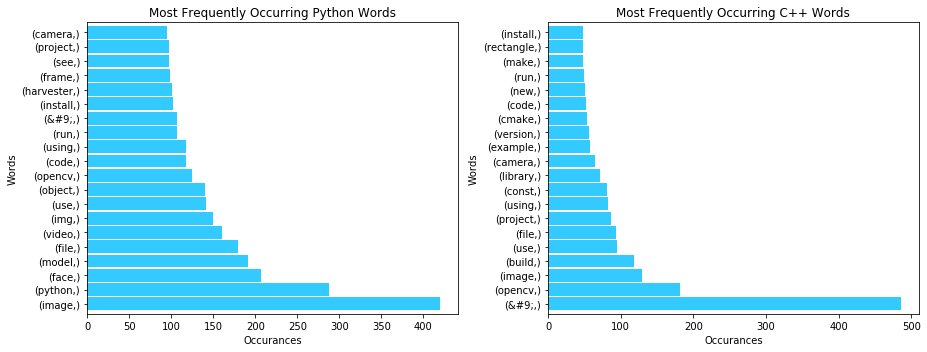

In [25]:
# Single Word Subplots (Python and C++) 
single_python_words.sort_values().plot.barh(color='deepskyblue', width=.9, align='center', figsize=(10, 6))
single_c_plus_plus_words.sort_values().plot.barh(color='deepskyblue', width=.9, figsize=(10, 6))
single_all_words.sort_values().plot.barh(color='deepskyblue', width=.9, figsize=(10, 6))

plt.subplot(121)
single_python_words.plot.barh(color='deepskyblue', width=.9, align='center', figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring Python Words')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.subplot(122)
single_c_plus_plus_words.plot.barh(color='deepskyblue', width=.9, figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring C++ Words')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Occurances')

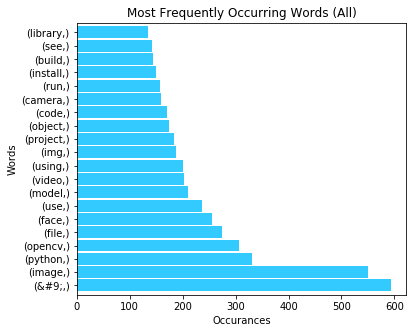

In [26]:
# Single Word Subplots (All) 
plt.subplot(121)
single_all_words.plot.barh(color='deepskyblue', width=.9, align='center', figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring Words (All)')
plt.ylabel('Words')
plt.xlabel('Occurances')

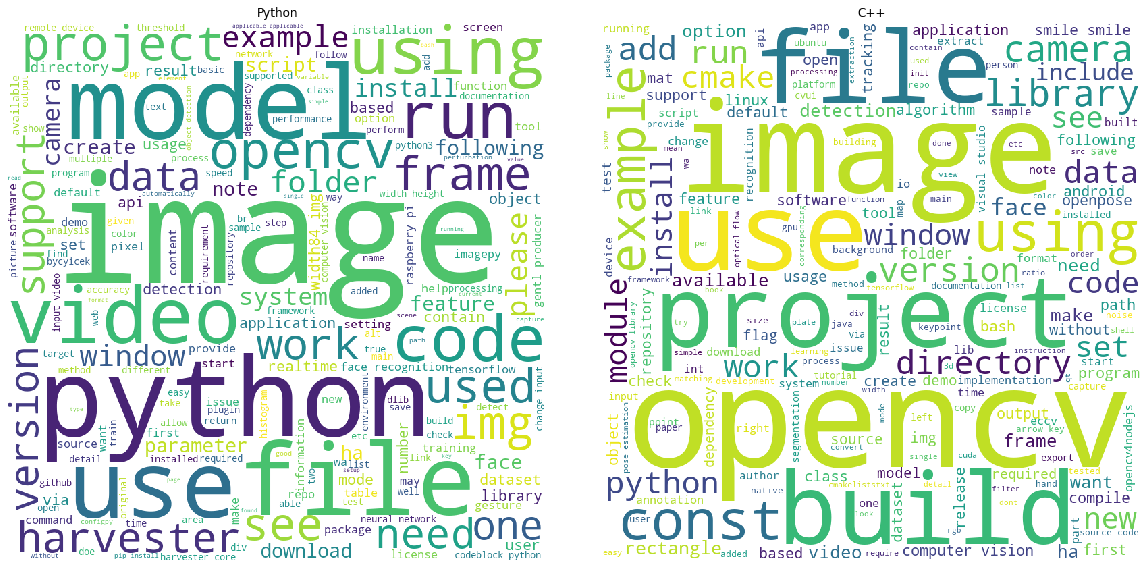

In [27]:
# Single Word, Word Clouds
python_cloud = WordCloud(background_color='white',
                      height=800, width=800).generate(python_words)

c_plus_plus_cloud = WordCloud(background_color='white', 
                      height=800, width=800).generate(c_plus_plus_words)

plt.figure(figsize=(15,15))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

# imshow => display data as an image
axs[0].imshow(python_cloud)
axs[1].imshow(c_plus_plus_cloud)

axs[0].set_title('Python')
axs[1].set_title('C++')

for ax in axs: ax.axis('off')

### Do different programming languages use a different number of unique words?

### Most Common Bigrams

In [28]:
# Added 'Bigram' column to dataframe
train['bigrams'] = [list(nltk.ngrams(wordlist, 2)) for wordlist in train.words]
train.head()

,language,text_filtered,words,bigrams
152,C++,opencv c stereo camera calibration repository ...,"[opencvstereo, camera, calibration, repository...","[(opencvstereo, camera), (camera, calibration)..."
162,python,objecttracker imagedocsimagescoverimage1png _r...,"[objecttracker, imagedocsimagescoverimage1png,...","[(objecttracker, imagedocsimagescoverimage1png..."
157,C++,cmaketemplates cmake template 1 overview conve...,"[cmaketemplates, cmake, templateoverview, conv...","[(cmaketemplates, cmake), (cmake, templateover..."
50,python,introduction imagepy open source image process...,"[introduction, imagepy, open, source, image, p...","[(introduction, imagepy), (imagepy, open), (op..."
7,python,english docreadme_enmd 1 2 3 4 5 6 7 8 9 10 11...,"[english, docreadmeenmd246810, 11, window, 10x...","[(english, docreadmeenmd246810), (docreadmeenm..."


In [29]:
# Create variables for series
python_bigrams = pd.Series(list(nltk.ngrams(python_words.split(), 2))).value_counts().head(20) 
c_plus_plus_bigrams = pd.Series(list(nltk.ngrams(c_plus_plus_words.split(), 2))).value_counts().head(20)

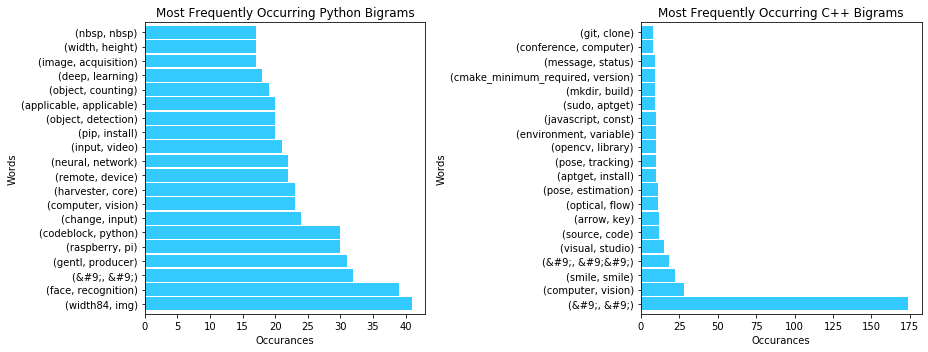

In [30]:
# Bigram Subplots 
python_bigrams.sort_values().plot.barh(color='deepskyblue', width=.9, align='center', figsize=(10, 6))
c_plus_plus_bigrams.sort_values().plot.barh(color='deepskyblue', width=.9, figsize=(10, 6))

plt.subplot(121)
python_bigrams.plot.barh(color='deepskyblue', width=.9, align='center', figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring Python Bigrams')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.subplot(122)
c_plus_plus_bigrams.plot.barh(color='deepskyblue', width=.9, figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring C++ Bigrams')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.tight_layout()
plt.show()

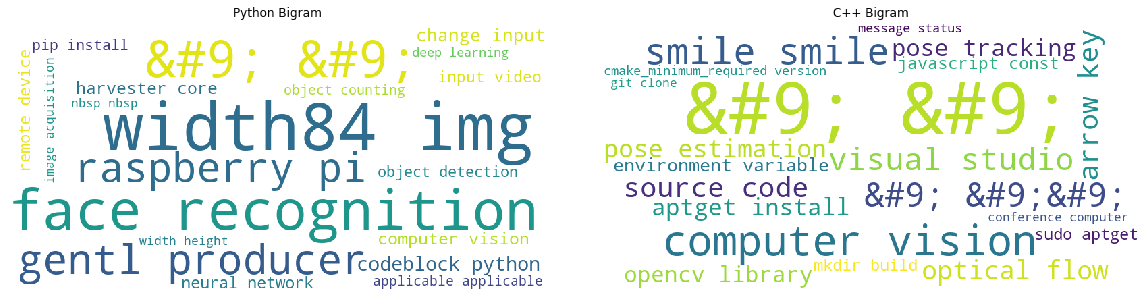

In [31]:
# Bigram Word Clouds
python_data = {k[0] + ' ' + k[1]: v for k, v in python_bigrams.to_dict().items()}
c_plus_plus_data = {k[0] + ' ' + k[1]: v for k, v in c_plus_plus_bigrams.to_dict().items()}

python_bigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(python_data)

c_plus_plus_bigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(c_plus_plus_data)


plt.figure(figsize=(15,15))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

axs[0].imshow(python_bigram_cloud)
axs[1].imshow(c_plus_plus_bigram_cloud)

axs[0].set_title('Python Bigram')
axs[1].set_title('C++ Bigram')

for ax in axs: ax.axis('off')

### Most Common Trigrams

In [32]:
# Added 'Trigram' column to dataframe
train['trigrams'] = [list(nltk.ngrams(wordlist, 3)) for wordlist in train.words]
train.head()

,language,text_filtered,words,bigrams,trigrams
152,C++,opencv c stereo camera calibration repository ...,"[opencvstereo, camera, calibration, repository...","[(opencvstereo, camera), (camera, calibration)...","[(opencvstereo, camera, calibration), (camera,..."
162,python,objecttracker imagedocsimagescoverimage1png _r...,"[objecttracker, imagedocsimagescoverimage1png,...","[(objecttracker, imagedocsimagescoverimage1png...","[(objecttracker, imagedocsimagescoverimage1png..."
157,C++,cmaketemplates cmake template 1 overview conve...,"[cmaketemplates, cmake, templateoverview, conv...","[(cmaketemplates, cmake), (cmake, templateover...","[(cmaketemplates, cmake, templateoverview), (c..."
50,python,introduction imagepy open source image process...,"[introduction, imagepy, open, source, image, p...","[(introduction, imagepy), (imagepy, open), (op...","[(introduction, imagepy, open), (imagepy, open..."
7,python,english docreadme_enmd 1 2 3 4 5 6 7 8 9 10 11...,"[english, docreadmeenmd246810, 11, window, 10x...","[(english, docreadmeenmd246810), (docreadmeenm...","[(english, docreadmeenmd246810, 11), (docreadm..."


In [33]:
# Create variables for series
python_trigrams = pd.Series(list(nltk.ngrams(python_words.split(), 3))).value_counts().head(20)
c_plus_plus_trigrams = pd.Series(list(nltk.ngrams(c_plus_plus_words.split(), 3))).value_counts().head(20)

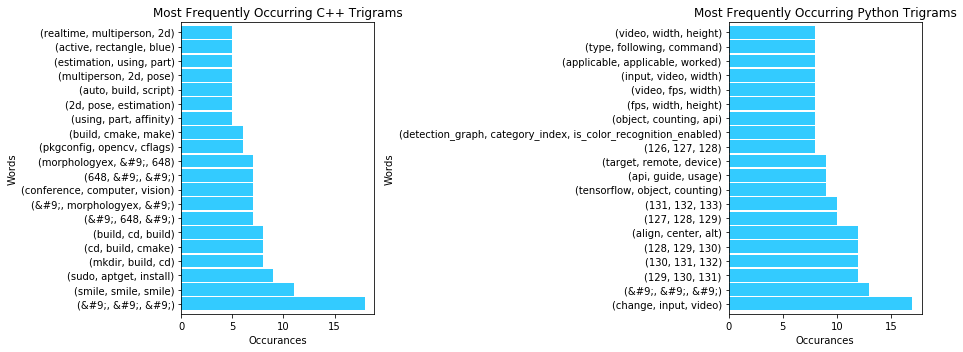

In [34]:
# Trigram Subplots 
# Switched Python and C++ graphs around to better align in this format
# Pay attention to the titles and labels
python_trigrams.sort_values().plot.barh(color='deepskyblue', width=.9, align='center', figsize=(10, 6))
c_plus_plus_trigrams.sort_values().plot.barh(color='deepskyblue', width=.9, figsize=(10, 6))

plt.subplot(121)
c_plus_plus_trigrams.plot.barh(color='deepskyblue', width=.9, figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring C++ Trigrams')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.subplot(122)
python_trigrams.plot.barh(color='deepskyblue', width=.9, align='center', figsize=(13, 5), alpha=.8)
plt.title('Most Frequently Occurring Python Trigrams')
plt.ylabel('Words')
plt.xlabel('Occurances')

plt.tight_layout()
plt.show()

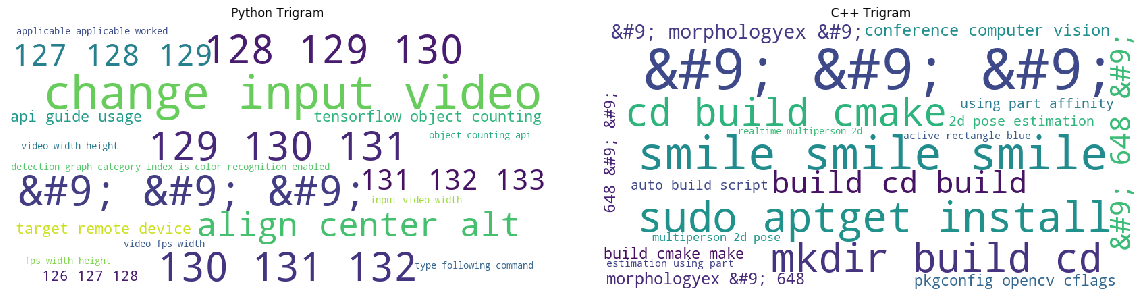

In [35]:
# Trigram Word Clouds
python_tridata = {k[0] + ' ' + k[1]+ ' ' + k[2]: v for k, v in python_trigrams.to_dict().items()}
c_plus_plus_tridata = {k[0] + ' ' + k[1]+ ' ' + k[2]: v for k, v in c_plus_plus_trigrams.to_dict().items()}

python_trigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(python_tridata)

c_plus_plus_trigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(c_plus_plus_tridata)


plt.figure(figsize=(15,15))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

axs[0].imshow(python_trigram_cloud)
axs[1].imshow(c_plus_plus_trigram_cloud)

axs[0].set_title('Python Trigram')
axs[1].set_title('C++ Trigram')

for ax in axs: ax.axis('off')

### What does the distribution of IDFs look like for the most common words?

In [36]:
# This is a function that takes in a word and generates its IDF for the whole dataframe
def idf(word):
    n_occurences = sum([1 for doc in train.text_filtered if word in doc])
    return np.log(len(df.words) / n_occurences)

In [37]:
# Now we need to make a unique word list so that there aren't any duplicate words
unique_words = pd.Series(' '.join(train.text_filtered).split()).unique()

In [38]:
# Put the unique words into a dataframe
idf_words = (pd.DataFrame(dict(word=unique_words))
# calculate the idf for each word
 .assign(idf=lambda df: df.word.apply(idf))
# set the data frames index as the word for that row
 .set_index('word')
# sort values to show max
 .sort_values(by='idf', ascending=False))
idf_words.head(10)

,idf
word,
recognitionba,5.192957
netherlands,5.192957
2_4_httpwwwwoshicvercomthirdsection2_4_,5.192957
2_5_httpwwwwoshicvercomthirdsection2_5_,5.192957
classcaptiontextspan,5.192957
3_1_httpwwwwoshicvercomfourthsection3_1_,5.192957
3_2_httpwwwwoshicvercomfourthsection3_2_,5.192957
3_3_httpwwwwoshicvercomfourthsection3_3_,5.192957
4_1_httpwwwwoshicvercomfifthsection4_1_,5.192957


In [39]:
# Looking at some summary statistics of the idf dataframe
idf_words.describe()

,idf
count,11819.000000
mean,4.610923
std,1.030691
min,0.510826
25%,4.499810
50%,5.192957
75%,5.192957
max,5.192957


In [40]:
# Create empty dataframe to store idfs for top 5 most common python words
top_five_python = pd.DataFrame()
# for loop goes through top 5 most common python words and generates its idf before appending it to dataframe
for word in python_freq.head().index:
    hold = idf_words[idf_words.index == word]
    top_five_python = top_five_python.append(hold)

In [41]:
# sort values so that larger idf are on top and show
top_five_python.sort_values(by='idf', ascending=False)

,idf
word,
model,1.504077
face,1.261131
file,1.003302
python,0.888892
image,0.849151


In [42]:
# Create empty dataframe to store idfs for top 5 most common C++ words
top_five_cplus2 = pd.DataFrame()
# for loop goes through top 5 most common C++ words and generates its idf before appending it to dataframe
for word in c_plus_plus_freq.head().index:
    hold = idf_words[idf_words.index == word]
    top_five_cplus2 = top_five_cplus2.append(hold)

In [43]:
# sort values so that larger idf are on top and show
top_five_cplus2.sort_values(by='idf', ascending=False)

,idf
word,
&#9;,2.197225
build,1.222665
image,0.849151
use,0.798508
opencv,0.618246


**Takeaways:**  
Python most common words has one with a huge idf but other than that remains consistent with C++

### Does the length of the README vary by programming language?

In [44]:
# First we need to make a new column that contains the length of the filtered readme
train['doc_len'] = [len(x) for x in train.words]
train.head()

,language,text_filtered,words,bigrams,trigrams,doc_len
152,C++,opencv c stereo camera calibration repository ...,"[opencvstereo, camera, calibration, repository...","[(opencvstereo, camera), (camera, calibration)...","[(opencvstereo, camera, calibration), (camera,...",172
162,python,objecttracker imagedocsimagescoverimage1png _r...,"[objecttracker, imagedocsimagescoverimage1png,...","[(objecttracker, imagedocsimagescoverimage1png...","[(objecttracker, imagedocsimagescoverimage1png...",195
157,C++,cmaketemplates cmake template 1 overview conve...,"[cmaketemplates, cmake, templateoverview, conv...","[(cmaketemplates, cmake), (cmake, templateover...","[(cmaketemplates, cmake, templateoverview), (c...",931
50,python,introduction imagepy open source image process...,"[introduction, imagepy, open, source, image, p...","[(introduction, imagepy), (imagepy, open), (op...","[(introduction, imagepy, open), (imagepy, open...",1553
7,python,english docreadme_enmd 1 2 3 4 5 6 7 8 9 10 11...,"[english, docreadmeenmd246810, 11, window, 10x...","[(english, docreadmeenmd246810), (docreadmeenm...","[(english, docreadmeenmd246810, 11), (docreadm...",112


In [45]:
# Now lets look at some summary statistics
train.groupby(train.language).doc_len.describe()

,count,mean,std,min,25%,50%,75%,max
language,,,,,,,,
C++,47.0,319.489362,299.774616,7.0,120.5,192.0,366.5,1396.0
python,61.0,479.770492,661.176461,3.0,100.0,249.0,680.0,3719.0


**Takeaways:** Python on average tends to be slightly longer than C++ readmes but python also has a wider range of values with a much bigger standard deviation.

### Comparing Top Ten Words From Each Language

In [46]:
# Find the top 10 word counts for python words
top_ten_python = word_counts['python'].sort_values(ascending=False).head(10)
# Find the top 10 word counts for C++ words
top_ten_cplus2 = word_counts['C++'].sort_values(ascending=False).head(10)
# Add both of these lists together
top_ten_both = list(top_ten_python.index) + list(top_ten_cplus2.index)
# Create a dataframe from the index of both top 10 lists into one top 20 list
top_ten_combined = word_counts[word_counts.index.isin(top_ten_both)]

In [47]:
top_ten_combined

,All,python,C++
&#9;,593,107,486
build,144,25,119
const,81,0,81
face,255,207,48
file,274,180,94
image,550,420,130
img,187,150,37
library,135,64,71
model,211,191,20
object,175,140,35


In [48]:
# Add the percent breakdown of word count by language
word_counts['pct_python'] = word_counts['python'] / word_counts['All']
word_counts['pct_cplus2'] = word_counts['C++'] / word_counts['All']

word_counts.head()

,All,python,C++,pct_python,pct_cplus2
&#9;,593,107,486,0.180438,0.819562
&#9;&#9;,19,0,19,0.000000,1.000000
&#9;8,1,1,0,1.000000,0.000000
&#9;chars_filled,1,1,0,1.000000,0.000000
&#9;completing,1,1,0,1.000000,0.000000


In [49]:
word_counts.All.sort_values()

untitledhttpscloudgithubusercontentcomassets735354725346609effb5106290f11e78426788a10fd4e2fpngaligncenter      0
artwx_gzhjpg                                                                                                   0
rahmansimpleopencvcalculator                                                                                   0
raftlibhttpraftlibiolibrary                                                                                    0
matbgrconverttocvcv_32sc3                                                                                      1
                                                                                                            ... 
file                                                                                                         274
opencv                                                                                                       306
python                                                                                          

In [50]:
# There are words in word counts with 0 for values so we will be dropping these
word_counts = word_counts[word_counts['All'] != 0]
word_counts['All'].sort_values()

zxingport        1
kazuhiro         1
kbddkbd          1
kbdesckbd        1
kcachegrind      1
              ... 
file           274
opencv         306
python         331
image          550
&#9;           593
Name: All, Length: 12261, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text yticklabel objects>)

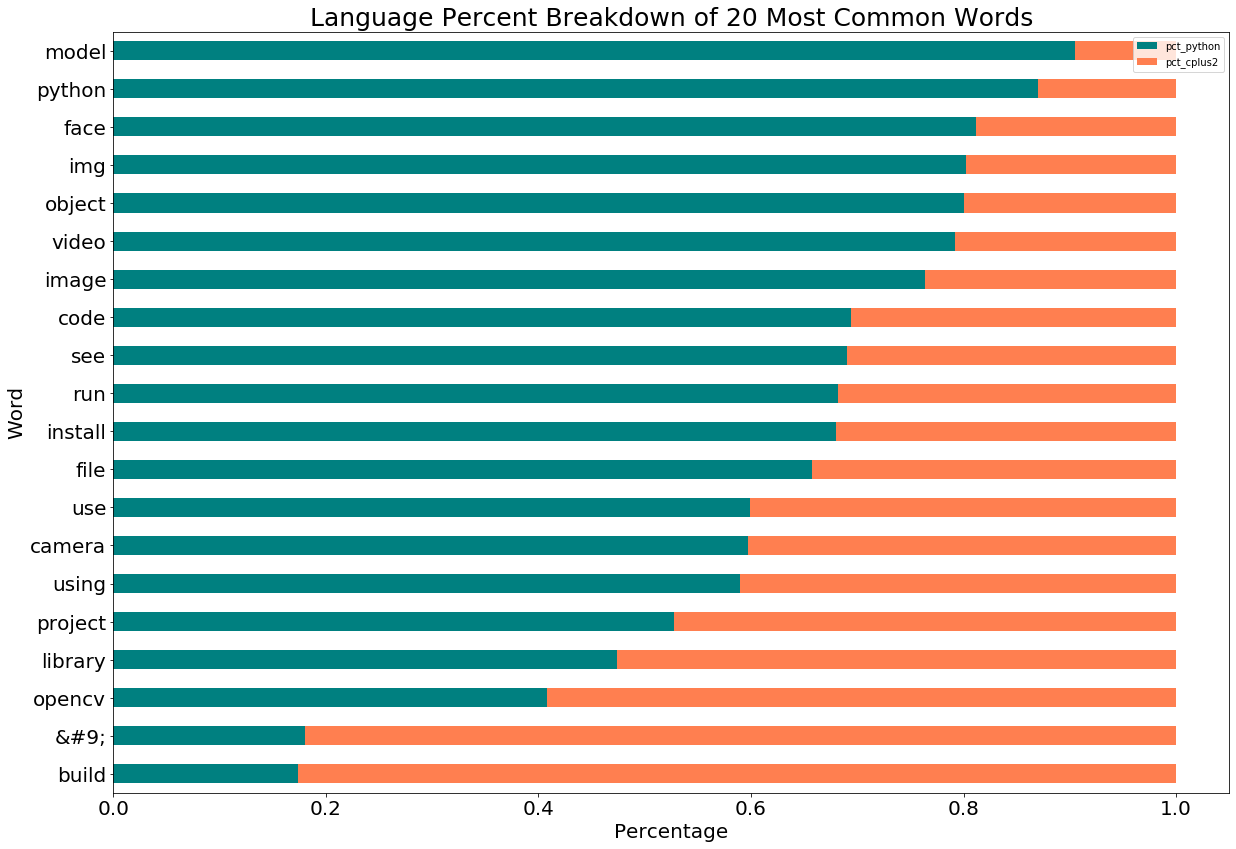

In [51]:
# Make a plot by sorting the values by all with the two columns for percent breakdown
(word_counts.sort_values(by='All')[['pct_python', 'pct_cplus2']]
 # Take the top 20 values and sort them by percent python
 .tail(20).sort_values(by='pct_python')
 # Make this a stacked plot
 .plot.barh(stacked=True, figsize=(20,14), color={'teal', 'coral'}))
# Set the title
plt.title('Language Percent Breakdown of 20 Most Common Words', fontsize=25)
# Set the X and Y label
plt.xlabel('Percentage', fontsize=20)
plt.ylabel('Word', fontsize=20)
# Change x and y tick size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

### Trimming Train
Now we will trim train down so that we can add features before pushing into modeling.

In [52]:
train = train.drop(columns=['bigrams', 'words', 'trigrams'])
validate = validate.drop(columns=['words'])
test = test.drop(columns=['words'])
train.head()

,language,text_filtered,doc_len
152,C++,opencv c stereo camera calibration repository ...,172
162,python,objecttracker imagedocsimagescoverimage1png _r...,195
157,C++,cmaketemplates cmake template 1 overview conve...,931
50,python,introduction imagepy open source image process...,1553
7,python,english docreadme_enmd 1 2 3 4 5 6 7 8 9 10 11...,112


### Feature Engineering

In [53]:
# Create column that checks for the word model in text in each data set
train['has_model'] = train.text_filtered.str.contains('model')
validate['has_model'] = validate.text_filtered.str.contains('model')
test['has_model'] = test.text_filtered.str.contains('model')

# Create column that checks for the word build in text in each data set
train['has_build'] = train.text_filtered.str.contains('build')
validate['has_build'] = validate.text_filtered.str.contains('build')
test['has_build'] = test.text_filtered.str.contains('build')

# Create column that checks for the word python in text in each data set
train['has_python'] = train.text_filtered.str.contains('python')
validate['has_python'] = validate.text_filtered.str.contains('python')
test['has_python'] = test.text_filtered.str.contains('python')

# Create column that checks for the word supported or aligncentersupported in text in each data set
train['has_supported'] = (train.text_filtered.str.contains('supported') | train.text_filtered.str.contains('aligncentersupported'))
validate['has_supported'] = (validate.text_filtered.str.contains('supported') | validate.text_filtered.str.contains('aligncentersupported'))
test['has_supported'] = (test.text_filtered.str.contains('supported') | test.text_filtered.str.contains('aligncentersupported'))

# Create column that checks for the word tdtd in text in each data set
train['has_tdtd'] = train.text_filtered.str.contains('tdtd')
validate['has_tdtd'] = validate.text_filtered.str.contains('tdtd')
test['has_tdtd'] = test.text_filtered.str.contains('tdtd')

In [84]:
train.head()

,language,text_filtered,doc_len,has_model,has_build,has_python,has_supported,has_tdtd,baseline,python_prediction,build_prediction,bag_prediction,tfidf_prediction,combo_prediction
152,C++,opencv c stereo camera calibration repository ...,172,1,1,0,1,1,python,C++,C++,C++,C++,C++
162,python,objecttracker imagedocsimagescoverimage1png _r...,195,0,0,1,0,0,python,python,python,python,python,python
157,C++,cmaketemplates cmake template 1 overview conve...,931,0,1,0,0,0,python,C++,C++,C++,C++,C++
50,python,introduction imagepy open source image process...,1553,0,1,1,0,0,python,python,C++,python,python,python
7,python,english docreadme_enmd 1 2 3 4 5 6 7 8 9 10 11...,112,0,0,1,0,0,python,python,python,python,python,python


## Hypothesis Tests

### Hypothesis Test 1

$H_0$: The word model being in a document and its programming language are independent  
$H_a$: The word model being in a document and its programming language are dependent  
a = .05

In [55]:
# We will be doing a chi2 test for this hypothesis
observed = pd.crosstab(train.language, train.has_model)

chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'has_model values\nchi2: {chi2}\tp: {p}')

has_model values
chi2: 7.707345247132688	p: 0.005499657330687403


### Hypothesis Test 2

$H_0$: The term supported or aligncentersupported being in a document and its programming language are independent  
$H_a$: The term supported or aligncentersupported being in a document is dependent on its programming language  
a = .05

In [56]:
# We will be doing a chi2 test for this hypothesis
observed = pd.crosstab(train.language, train.has_supported)

chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'has_supported values\nchi2: {chi2}\tp: {p}')

has_supported values
chi2: 3.5795749230372604	p: 0.05849411735753191


### Hypothesis Test 3

$H_0$: The term tdtd being in a document and its programming language are independent  
$H_a$: The term tdtd being in a document and its programming language are dependent  
a = .05

In [57]:
# We will be doing a chi2 test for this hypothesis
observed = pd.crosstab(train.language, train.has_tdtd)

chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'has_tdtd values\nchi2: {chi2}\tp: {p}')

has_tdtd values
chi2: 0.0	p: 1.0


### Hypothesis Test 4

$H_0$: The word python being in a document and its programming language are independent  
$H_a$: The word python being in a document and its programming language are dependent  
a = .05

In [58]:
# We will be doing a chi2 test for this hypothesis
observed = pd.crosstab(train.language, train.has_python)

chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'has_python values\nchi2: {chi2}\tp: {p}')

has_python values
chi2: 32.795092225938156	p: 1.0240305619829398e-08


### Hypothesis Test 5

$H_0$: The word build being in a document and its programming language are independent  
$H_a$: The word build being in a document and its programming language are dependent  
a = .05

In [59]:
# We will be doing a chi2 test for this hypothesis
observed = pd.crosstab(train.language, train.has_build)

chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'has_build values\nchi2: {chi2}\tp: {p}')

has_build values
chi2: 6.242048124365454	p: 0.01247521257243824


### Hypothesis Test 6

$H_0$: The length of a documents is independent of its programming language  
$H_a$: The longer a document is the more likely it is to be a python document  
a = .05

In [60]:
# We will be performing a two-tailed t-test for this hypothesis
x1 = train[train.language == 'python'].doc_len
x2 = train[train.language == 'C++'].doc_len

stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=1.5429955287348576, pvalue=0.12581209061957566)

### Hypothesis Test Takeaways:
The appearance of the words **python**, **build**, and **model** has a low enough p value to be correlated with what programming language the repo is for. The word supported is just almost low enough so it will be included as part of a model.

## Modeling 

- Use the programming language of the repository as a predictive label.  


- Fit different models and using different representations of the text (e.g. simple bag of words, TF-IDF values).  


- Built a function that will take in the text of a README file and predict the programming language of repo.  

In [61]:
# We need to convert all our true false features into 1s and 0s
train['has_model'] = np.where((train.has_model == True), 1, 0)
train['has_build'] = np.where((train.has_build == True), 1, 0)
train['has_python'] = np.where((train.has_python == True), 1, 0)
train['has_supported'] = np.where((train.has_model == True), 1, 0)
train['has_tdtd'] = np.where((train.has_model == True), 1, 0)

validate['has_model'] = np.where((validate.has_model == True), 1, 0)
validate['has_build'] = np.where((validate.has_build == True), 1, 0)
validate['has_python'] = np.where((validate.has_python == True), 1, 0)
validate['has_supported'] = np.where((validate.has_model == True), 1, 0)
validate['has_tdtd'] = np.where((validate.has_model == True), 1, 0)

test['has_model'] = np.where((test.has_model == True), 1, 0)
test['has_build'] = np.where((test.has_build == True), 1, 0)
test['has_python'] = np.where((test.has_python == True), 1, 0)
test['has_supported'] = np.where((test.has_python == True), 1, 0)
test['has_tdtd'] = np.where((test.has_python == True), 1, 0)

### Baseline

In [71]:
train.language.value_counts()

python    61
C++       47
Name: language, dtype: int64

In [72]:
# Create and set baseline to python as it's the majority
train['baseline'] = 'python'
train.head()

,language,text_filtered,doc_len,has_model,has_build,has_python,has_supported,has_tdtd,baseline,python_prediction,build_prediction,bag_prediction,tfidf_prediction,combo_prediction
152,C++,opencv c stereo camera calibration repository ...,172,1,1,0,1,1,python,C++,C++,C++,C++,C++
162,python,objecttracker imagedocsimagescoverimage1png _r...,195,0,0,1,0,0,python,python,python,python,python,python
157,C++,cmaketemplates cmake template 1 overview conve...,931,0,1,0,0,0,python,C++,C++,C++,C++,C++
50,python,introduction imagepy open source image process...,1553,0,1,1,0,0,python,python,C++,python,python,python
7,python,english docreadme_enmd 1 2 3 4 5 6 7 8 9 10 11...,112,0,0,1,0,0,python,python,python,python,python,python


In [73]:
print(classification_report(train.language, train.baseline))

              precision    recall  f1-score   support

         C++       0.00      0.00      0.00        47
      python       0.56      1.00      0.72        61

    accuracy                           0.56       108
   macro avg       0.28      0.50      0.36       108
weighted avg       0.32      0.56      0.41       108



Our baseline model has an accuracy of 56%

## Training Models

### has_python Model

In [74]:
# Set our target variable
y_train = train.language

In [75]:
# Set independent variable
x_train_python = train[['has_python']]

# Create LogReg
lr_python = LogisticRegression(random_state=123)

# Fit LogReg
lr_python.fit(x_train_python, y_train)

# Create prediction column using .predict
train['python_prediction'] = lr_python.predict(x_train_python)

# Use classification_report to see results
print(classification_report(train.language, train.python_prediction))

              precision    recall  f1-score   support

         C++       0.85      0.62      0.72        47
      python       0.76      0.92      0.83        61

    accuracy                           0.79       108
   macro avg       0.80      0.77      0.77       108
weighted avg       0.80      0.79      0.78       108



### has_build Model

In [76]:
# Set independent variable
x_train_build = train[['has_build']]

# Create LogReg
lr_build = LogisticRegression(random_state=123)

# Fit LogReg
lr_build.fit(x_train_build, y_train)

# Create column for prediction using .predict
train['build_prediction'] = lr_build.predict(x_train_build)

# Here's the results
print(classification_report(train.language, train.build_prediction))

              precision    recall  f1-score   support

         C++       0.57      0.64      0.60        47
      python       0.69      0.62      0.66        61

    accuracy                           0.63       108
   macro avg       0.63      0.63      0.63       108
weighted avg       0.64      0.63      0.63       108



### Bag of Words Model

In [77]:
# Create CountVectorizer
vectorizer = CountVectorizer(stop_words='english', 
                             min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

# Fit vectorizer
vectorizer.fit(train.text_filtered)

# Get dictionary
vectorizer.get_feature_names()

# Transform each sentence in vector space
x_bag = vectorizer.transform(train.text_filtered)

# Create LogReg
lr_bag = LogisticRegression(random_state=123)

# Fit LogReg
lr_bag = lr_bag.fit(x_bag, y_train)

# Create prediction column using .predict
train['bag_prediction'] = lr_bag.predict(x_bag)

print(classification_report(train.language, train.bag_prediction))

              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        47
      python       1.00      1.00      1.00        61

    accuracy                           1.00       108
   macro avg       1.00      1.00      1.00       108
weighted avg       1.00      1.00      1.00       108



This model has an incredible 100% but it is most certainly overfitting.

### TF-IDF Model

In [78]:
# Create tfidf vectorizer
tfidf = TfidfVectorizer(stop_words='english', min_df = 20,
                             ngram_range=(1,2), 
                             binary=True)

# Fit and transform filtered text data
tfidf_matrix = tfidf.fit_transform(train.text_filtered)

# Get vocabulary
tfidf.vocabulary_

# Transform to document-term matrix
vector_spaces = tfidf.transform(train.text_filtered)

# Create independent variable
x_tf = tfidf_matrix

# Create LogReg
lr_tf = LogisticRegression(random_state=123)

# Fit LogReg
lr_tf = lr_tf.fit(x_tf, y_train)

# Create prediction column 
train['tfidf_prediction'] = lr_tf.predict(x_tf)

print(classification_report(train.language, train.tfidf_prediction))

              precision    recall  f1-score   support

         C++       0.98      0.85      0.91        47
      python       0.90      0.98      0.94        61

    accuracy                           0.93       108
   macro avg       0.94      0.92      0.92       108
weighted avg       0.93      0.93      0.93       108



This model also has a high accuracy with 93%, it may be overfitting too.

### Combined Terms Model

In [85]:
# Create x variable
x_train_combo = train[['has_model', 'has_build', 'has_python', 'has_supported']]

# Create LogReg
lr_combo = LogisticRegression(random_state=123)

# Fit LogReg
lr_combo.fit(x_train_combo, y_train)

# Create prediction column using .predict
train['combo_prediction'] = lr_combo.predict(x_train_combo)

print(classification_report(train.language, train.combo_prediction))

              precision    recall  f1-score   support

         C++       0.85      0.62      0.72        47
      python       0.76      0.92      0.83        61

    accuracy                           0.79       108
   macro avg       0.80      0.77      0.77       108
weighted avg       0.80      0.79      0.78       108



This model still has a great accuracy of 79%

### Training Takeaways:
Top 3 training models is **Bag of Words**, **TF-IDF**, and **Combined Terms**. These will move on to validate

## Validation Models

### Bag of Words Model

In [86]:
# Fit the model on validate
v_bow = vectorizer.transform(validate.text_filtered)

# Create prediction column for validate
validate['bag_prediction'] = lr_bag.predict(v_bow)

print(classification_report(validate.language, validate.bag_prediction))

              precision    recall  f1-score   support

         C++       0.76      0.76      0.76        17
      python       0.79      0.79      0.79        19

    accuracy                           0.78        36
   macro avg       0.78      0.78      0.78        36
weighted avg       0.78      0.78      0.78        36



This model scored a 78% accuracy on validate.

### TD-IDF Model

In [87]:
tfidf_matrix = tfidf.transform(validate.text_filtered)

vector_spaces = tfidf.transform(validate.text_filtered)

x_tf = tfidf_matrix

validate['tfidf_prediction'] = lr_tf.predict(x_tf)

print(classification_report(validate.language, validate.tfidf_prediction))

              precision    recall  f1-score   support

         C++       0.83      0.59      0.69        17
      python       0.71      0.89      0.79        19

    accuracy                           0.75        36
   macro avg       0.77      0.74      0.74        36
weighted avg       0.77      0.75      0.74        36



This model scored a 75% on validate.

### Combined Terms Model

In [90]:
x_validate_combo = validate[['has_model', 'has_build', 'has_python', 'has_supported']]
y_validate = validate.language

lr_combo.fit(x_validate_combo, y_validate)

validate['combo_prediction'] = lr_combo.predict(x_validate_combo)

print(classification_report(validate.language, validate.combo_prediction))

              precision    recall  f1-score   support

         C++       0.93      0.76      0.84        17
      python       0.82      0.95      0.88        19

    accuracy                           0.86        36
   macro avg       0.87      0.86      0.86        36
weighted avg       0.87      0.86      0.86        36



This model scored an 86% on validate.

### Validation Takeaways:
While the TF-IDF and Bag of Words models both took a big hit to accuracy on the validate data, the Combined Terms model not only maintained its accuracy but it improved from training to validate.  

The **Combined Terms** model will be the model to move forwards into Test.

## Test Model

### Combined Terms Model

In [91]:
x_test_combo = test[['has_model', 'has_build', 'has_python', 'has_supported']]
y_test = test.language

lr_combo.fit(x_test_combo, y_test)

test['combo_prediction'] = lr_combo.predict(x_test_combo)

print(classification_report(test.language, test.combo_prediction))

              precision    recall  f1-score   support

         C++       0.88      0.93      0.90        15
      python       0.95      0.90      0.93        21

    accuracy                           0.92        36
   macro avg       0.91      0.92      0.92        36
weighted avg       0.92      0.92      0.92        36



### Test Takeaways:
The model improved its accuracy once again going up to 92%

# Entire Dataset

Now we will test the model against the entire data set.

In [94]:
df = df.drop(columns='words')

In [95]:
df.head()

,language,text_filtered
0,C++,openframeworkshttpopenframeworkscc openframewo...
1,C++,repository opencvs extra module repository int...
2,python,repository deprecated tf20 rewrite visit https...
3,C++,opencv open source computer vision library res...
4,C++,mvision machine vision ai httpwwwhuaxiaozhuanc...


In [98]:
df['has_model'] = df.text_filtered.str.contains('model')

df['has_build'] = df.text_filtered.str.contains('build')

df['has_python'] = df.text_filtered.str.contains('python')

df['has_supported'] = (df.text_filtered.str.contains('supported') | df.text_filtered.str.contains('aligncentersupported'))

df['has_model'] = np.where((df.has_model == True), 1, 0)
df['has_build'] = np.where((df.has_build == True), 1, 0)
df['has_python'] = np.where((df.has_python == True), 1, 0)
df['has_supported'] = np.where((df.has_supported == True), 1, 0)

In [100]:
df.head()

,language,text_filtered,has_model,has_build,has_python,has_supported
0,C++,openframeworkshttpopenframeworkscc openframewo...,0,1,0,0
1,C++,repository opencvs extra module repository int...,1,1,0,0
2,python,repository deprecated tf20 rewrite visit https...,1,0,1,0
3,C++,opencv open source computer vision library res...,0,0,0,0
4,C++,mvision machine vision ai httpwwwhuaxiaozhuanc...,1,1,1,0


In [101]:
x_full_combo = df[['has_model', 'has_build', 'has_python', 'has_supported']]
y_full = df.language

lr_combo.fit(x_full_combo, y_full)

df['combo_prediction'] = lr_combo.predict(x_full_combo)

print(classification_report(df.language, df.combo_prediction))

              precision    recall  f1-score   support

         C++       0.88      0.71      0.78        79
      python       0.80      0.92      0.86       101

    accuracy                           0.83       180
   macro avg       0.84      0.81      0.82       180
weighted avg       0.83      0.83      0.82       180



The model maintained an 83% accuracy across the entire dataset.

## Conclusions/Takeaways

- Even though OpenCV is primarly written in C++, most words repos are written in Python  



- Repo Languages (out of 243 total most starred repos explored):  
    - Python 41.5% ; 101 repos  
    - C++ 32.5%, 79 repos  
    - Java 6.5%, 16 repos  
    
   
- We choose to only explore Python and C++ repos because these are the most significant   



- Combined total of 180 repos explored



- Most common words for Python and C++ combined are  &#9 ; , image, and opencv  



- Curious to know the meaning behind  &#9 ; ,could not find anything over it through Google search



- Final model maintained an 83% accuracy when introduced to the full dataset.

## Future Investigations

- Are similar patterns seen across other computer vision software repos, such as (Matlab, TensorFlow, and SimpleCV)?  


- Gather higher quantity of repo data.   


- Futher modeling and feature engineering could be conducted. 